<a href="https://colab.research.google.com/github/RodolfoViegas/RNN_PETR4/blob/master/Prepara%C3%A7%C3%A3o_das_series_temporais(sem_diff_e_sem_log_transform).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem de RNN para séries temporais PETR4 - de janeiro de 2000 a junho de 2020

Este trabalho tem por objetivo desenvolver uma rede neural recorrente LSTM que modele as séries temporais PETR4 da Petrobrás do tipo preferenciais, as sem direito a voto. Tais dados foram retirados do site *Yahoo! Finance*.

Será dada preferência a previsão dos valores de fechamento das ações (coluna Close no dataset). Assim fazendo um modelo univariado de RNN. A escolha da LSTM para os treinos deve-se ao melhor poder para lidar com sequência de grande tamanho. A rede possui 3 camadas escondidas, a primeira com 207 células de memória e a segunda com 100 e a última densamente conectada com 50 neurônios.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving PETR4.SA.csv to PETR4.SA.csv


In [3]:
df = pd.read_csv('/content/PETR4.SA.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,5.875,5.875,5.875,5.875,4.050183,3.538944e+10
1,2000-01-04,5.550,5.550,5.550,5.550,3.826131,2.886144e+10
2,2000-01-05,5.494,5.494,5.494,5.494,3.787526,4.303360e+10
3,2000-01-06,5.475,5.475,5.475,5.475,3.774427,3.405568e+10
4,2000-01-07,5.500,5.500,5.500,5.500,3.791661,2.091264e+10


In [5]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5138,2020-06-03,21.860001,21.910000,21.410000,21.469999,21.469999,86219700.0
5139,2020-06-04,21.389999,21.780001,21.040001,21.430000,21.430000,107401400.0
5140,2020-06-05,22.290001,23.030001,22.059999,22.100000,22.100000,114137700.0
5141,2020-06-08,22.549999,22.590000,22.010000,22.530001,22.530001,82444400.0
5142,2020-06-09,22.030001,22.040001,21.639999,21.719999,21.719999,96488300.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5143 entries, 0 to 5142
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5143 non-null   object 
 1   Open       5026 non-null   float64
 2   High       5026 non-null   float64
 3   Low        5026 non-null   float64
 4   Close      5026 non-null   float64
 5   Adj Close  5026 non-null   float64
 6   Volume     5026 non-null   float64
dtypes: float64(6), object(1)
memory usage: 281.4+ KB


In [7]:
# Exclusão de dados faltantes

df.dropna(inplace=True)

In [8]:
df.shape 

(5026, 7)

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

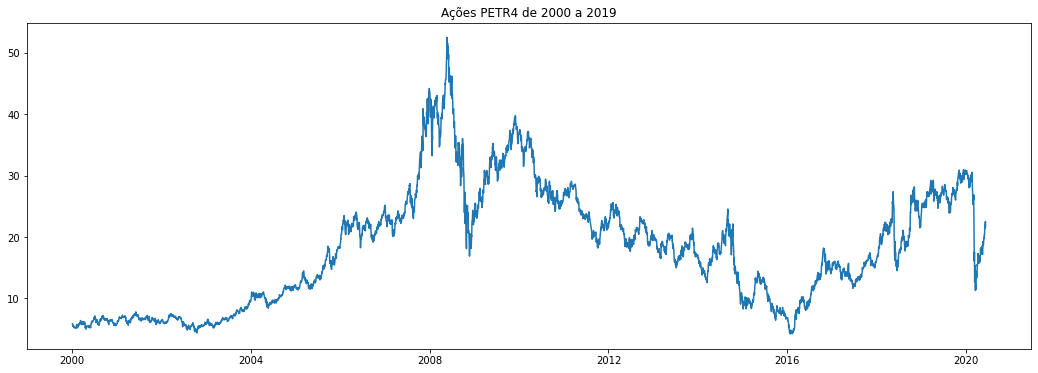

In [10]:
plt.figure(figsize=(18,6))
plt.title("Ações PETR4 de 2000 a 2019")
plt.plot(df['Date'],df['Close'])

plt.show()

## A primeira vista dos dados plotados é possível especular características de não-estacionaridade. A baixo foram realizados teste simples que indicam essa possibilidade.

In [11]:
# Média e variância da série

media = df['Close'].mean()
var = df['Close'].var()
print('média %f, variância %i' %(media, var))

média 18.000403, variância 90


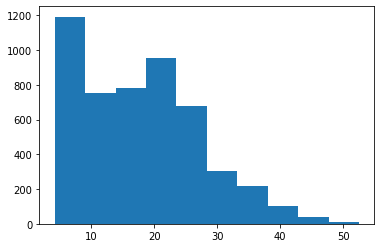

In [12]:
plt.hist(df['Close'])
plt.show()

In [13]:
# Média e variância de partes da séries quando particionada em duas

split = round(len(df['Close'])/2)
x = df['Close']
x1, x2 = x[0:split], x[split:]
media1, media2 = x1.mean(), x2.mean()
var1, var2 = x1.var(), x2.var()
print("X1 média %f, variância %f" %(media1,var1))
print("X2 média %f, variância %f" %(media2,var2))

X1 média 16.879320, variância 135.358284
X2 média 19.121487, variância 44.023526


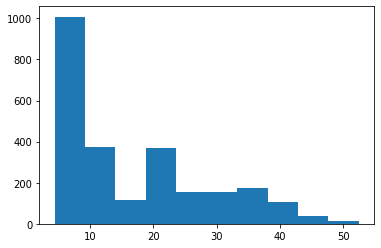

In [14]:
plt.hist(x1)
plt.show()

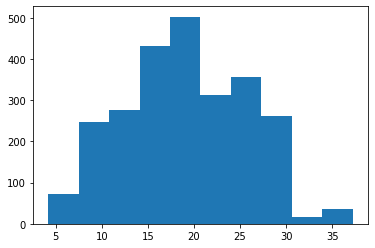

In [15]:
plt.hist(x2)
plt.show()

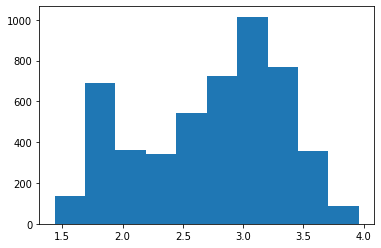

In [16]:
# Log transform para retirar a mudança da variância através do tempo deixando a séries linear.

logx= np.log(df.Close)
plt.hist(logx)
plt.show()

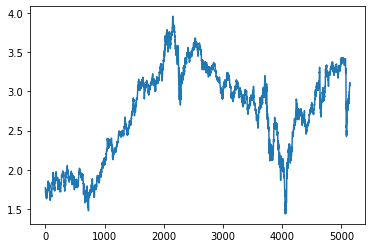

In [17]:
plt.plot(logx)
plt.show()

In [18]:

split = round(len(logx) / 2)
x1, x2 = logx[0:split], logx[split:]
mean1, mean2 = x1.mean(), x2.mean()
var1, var2 = x1.var(), x2.var()
print('x1 média %f, x1 variância %f' % (mean1, var1))
print('x2 média %f, x2 variância %f' % (mean1, var2))


x1 média 2.584394, x1 variância 0.490570
x2 média 2.584394, x2 variância 0.159889


In [19]:
# Definir quantidade para treino e teste
tamanho = int(np.ceil(df.shape[0]) * .75)
print(tamanho)

3769


In [20]:
# separar os valores da coluna Close e transformá-los para um vector numpy
data = df.filter(['Close'])
data = data.values

In [21]:
# Criação dos conjuntos de treino e teste a partir dos dados normalizados

train_data = data[:tamanho]
test_data = data[tamanho:]


In [22]:
train_data.shape

(3769, 1)

In [45]:
test_data.shape

(1257, 1)

In [23]:
# Remodelando os conjuntos de dados para tensores 2D, assim podendo normalizá-los

train_data = train_data.reshape((train_data.shape[0],1))
test_data = test_data.reshape((test_data.shape[0],1))

<Figure size 432x288 with 0 Axes>

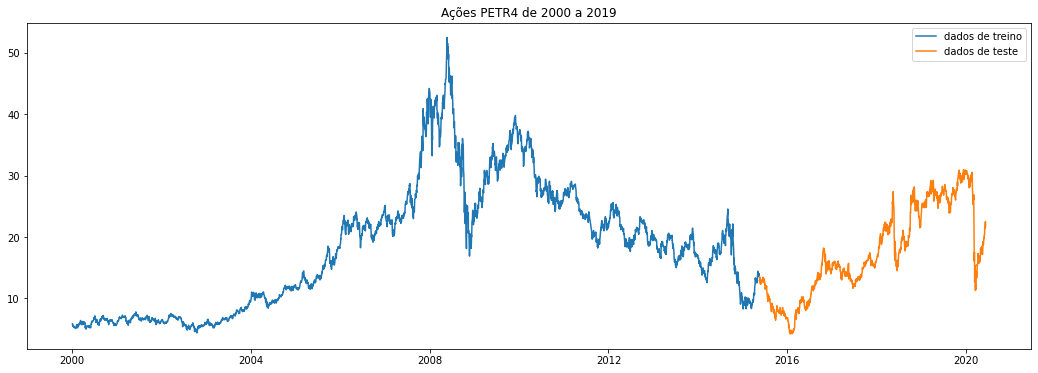

In [24]:
plt.clf()

#fig, ax = plt.subplots()

plt.figure(figsize=(18,6))

plt.title("Ações PETR4 de 2000 a 2019")
plt.plot(df['Date'].iloc[:tamanho],df['Close'].iloc[:tamanho], label='dados de treino')
plt.plot(df['Date'].iloc[tamanho:],df['Close'].iloc[tamanho:], label='dados de teste')
plt.legend()
plt.show()

In [25]:
# Normalização dos valores para serem entre 0 e 1

scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(train_data)

normalized = scaler.transform(train_data)

#inversed = scaler.inverse_transform(normalized)

In [26]:
# Separação dos dados em entradas (x) e saídas (y)

x_train=[]
y_train = []
for i in range(207,len(normalized)):
    x_train.append(normalized[i-207:i,0])
    y_train.append(normalized[i,0])

In [27]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [28]:
x_train.shape #(3914,60) (3767, 207)

(3562, 207)

In [29]:
# Remodelando o o conjunto treino para um tensor 3D

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [30]:
x_train.shape 

(3562, 207, 1)

# Construção da RNN

In [31]:
# Montagem da LSTM
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(207, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(50,activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 207, 207)          173052    
_________________________________________________________________
dropout (Dropout)            (None, 207, 207)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               123200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 301,353
Trainable params: 301,353
Non-trainable params: 0
__________________________________________________

In [32]:
model.compile(loss='mse',
              optimizer='sgd',
              metrics=["mae"])

In [33]:
history = model.fit(x_train,y_train ,epochs=300)

Epoch 1/300
112/112 [==============================] - 2s 22ms/step - loss: 0.0585 - mae: 0.1718
Epoch 2/300
112/112 [==============================] - 2s 21ms/step - loss: 0.0105 - mae: 0.0731
Epoch 3/300
112/112 [==============================] - 2s 21ms/step - loss: 0.0090 - mae: 0.0698
Epoch 4/300
112/112 [==============================] - 2s 21ms/step - loss: 0.0080 - mae: 0.0665
Epoch 5/300
112/112 [==============================] - 2s 21ms/step - loss: 0.0074 - mae: 0.0643
Epoch 6/300
112/112 [==============================] - 2s 21ms/step - loss: 0.0071 - mae: 0.0633
Epoch 7/300
112/112 [==============================] - 2s 21ms/step - loss: 0.0069 - mae: 0.0624
Epoch 8/300
112/112 [==============================] - 2s 21ms/step - loss: 0.0065 - mae: 0.0603
Epoch 9/300
112/112 [==============================] - 2s 21ms/step - loss: 0.0062 - mae: 0.0588
Epoch 10/300
112/112 [==============================] - 2s 21ms/step - loss: 0.0061 - mae: 0.0584
Epoch 11/300
112/112 [=======

### Prepação para testar o modelo

In [34]:
# Normalização do conjunto de teste
scaler2 = MinMaxScaler(feature_range=(-1,1))
scaler2 = scaler2.fit(test_data)

normalized_test = scaler2.transform(test_data)

In [35]:
# Criação de janelas

x_test=[]
y_test = []
for i in range(207,len(test_data)):
    x_test.append(normalized_test[i-207:i,0])
    y_test.append(normalized_test[i,0])

In [36]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [37]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [38]:
x_test.shape

(1050, 207, 1)

In [39]:
# Previsão do modelo

predicted = model.predict(x_test)

In [40]:
predicted = scaler2.inverse_transform(predicted)

In [41]:
y_test = np.reshape(y_test, (y_test.shape[0],1))
y_test = scaler2.inverse_transform(y_test)

In [42]:
from sklearn.metrics import mean_absolute_error


mae = mean_absolute_error(predicted, y_test)
print('MAE: ' + str(round(mae, 1)))

# Calculate the root mean squarred error (RMSE)
rmse = np.sqrt(np.mean(predicted - y_test)**2)
print('RMSE: ' + str(round(rmse, 1)))

MAE: 0.7
RMSE: 0.2


### Plotagem dos resultados

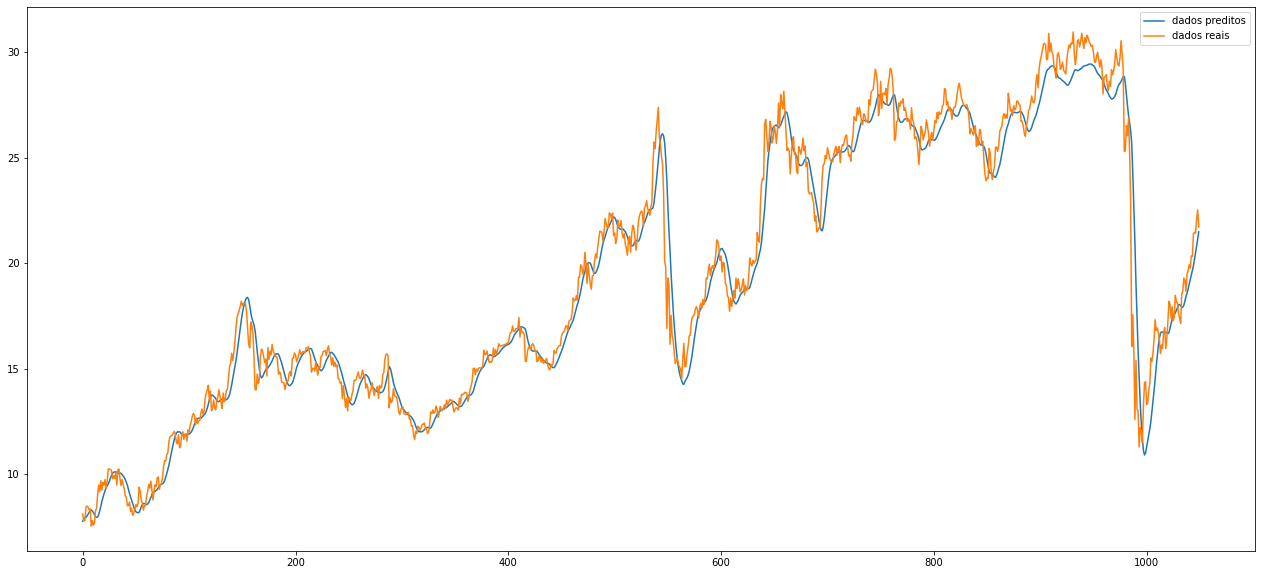

In [48]:
plt.clf()
plt.figure(figsize=(22,10))
plt.plot(predicted, label='dados preditos')
plt.plot(y_test, label='dados reais')
plt.legend()
plt.show()

# O modelo foi salvo para uso futuro

In [50]:
model.save('my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
from keras.models import load_model
 
# load model
model = load_model('/content/drive/My Drive/Colab Notebooks/my_model_sem_diff_sem_log')
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 207, 207)          173052    
_________________________________________________________________
dropout (Dropout)            (None, 207, 207)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               123200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 301,353
Trainable params: 301,353
Non-trainable params: 0
__________________________________________________